# CCC Metrics - proxifier logs



## set up the env
* run opne api script to generate the data file
* upload the file to /content folder
  * need to upload everytime when start a new session
  * name the file as openai.csv
  * sample data
  ```
  data = {
    'ref': [
        'This is the first sentence.',
    ],
    'gen3': [
        'sentence 1.',
    ],
    'gen4': [
        'sentence 1.',
    ]
}
  ```

In [ ]:
!pip install --quiet python-dotenv nltk rouge-score nubia-score transformers bert-score

import nltk
try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')
  nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 43.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
     ━━━━

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# import pandas as pd

# data = {
#     'ref': [
#         'This is the first sentence.',
#         'This is the second sentence.',
#         'This is the third sentence.',
#         'This is the fourth sentence.',
#         'This is the fifth sentence.',
#     ],
#     'gen3': [
#         'sentence 1.',
#         'sentence 2.',
#         'sentence 3.',
#         'sentence 4.',
#         'sentence 5.',
#     ],
#       'gen4': [
#       'sentence 1.',
#       'sentence 2.',
#       'sentence 3.',
#       'sentence 4.',
#       'sentence 5.',
#     ]
# }

# df = pd.DataFrame(data)

# df.to_csv('openai.csv', index=False)



## Lexical metrics:
* BLEU Score
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * 0.4-0.6 is considered reasonable and indicates some level of similarity
  * above 0.6 is considered quite good
  
* ROUGE Score
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * round 0.2-0.4 indicates some level of overlap
  * above 0.4 is considered good

* Meteor Score
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * 0.4-0.6 is considered reasonable and indicates some level of similarity
  * above 0.6 is considered quite good

In [ ]:
from transformers.models.switch_transformers.modeling_switch_transformers import SWITCH_TRANSFORMERS_INPUTS_DOCSTRING
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

from nltk.translate.meteor_score import meteor_score, single_meteor_score
from nltk import word_tokenize

def bleu(ref, gen):
  reference = ref
  generated = gen

  reference_tokens = reference.split()
  candidate_tokens = generated.split()

  smoother = SmoothingFunction()
  bleu_score = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoother.method4)
  if debug:
    print(f'BLEU4: {bleu_score}')
  return bleu_score


def rouge(ref, gen):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(ref, gen)
  if debug:
    for key in scores:
        print(f'{key}: {scores[key]}')
    print(f'rougeL: {scores["rougeL"].fmeasure}')
  return scores["rougeL"].fmeasure


def meteor(ref, gen):
  # ref_token =
  # score = meteor_score([word_tokenize(ref)], word_tokenize(gen), alpha = 0.9, beta = 3, gamma = 0.5)
  score = single_meteor_score(word_tokenize(ref), word_tokenize(gen))
  if debug:
    print(f'meteor: {score}')
  return score


import seaborn as sns
import matplotlib.pyplot as plt
def plot_results(scores, title):
  df_long = scores.melt(var_name='Metrics', value_name='Value')
  plt.figure(figsize=(5, 3))
  sns.boxplot(x='Metrics', y='Value', data=df_long, width=0.5, showfliers=False)
  sns.stripplot(x='Metrics', y='Value', data=df_long, jitter=True, color='black', alpha=0.5)

  plt.axhline(0.2, color='red', linestyle='--', label=f'Threshold 1: {0.2}')
  plt.axhline(0.4, color='green', linestyle='--', label=f'Threshold 2: {0.4}')

  plt.title(title)
  plt.show()

In [ ]:
def process(metrics, title):
  scores1 = df.apply(metrics, axis=1)
  print(scores1)
  print(f'mean: {scores1.mean(axis=0).to_numpy()}')
  print(f'median: {scores1.median(axis=0).to_numpy()}')
  print(f'max: {scores1.max(axis=0).to_numpy()}')
  print(f'min: {scores1.min(axis=0).to_numpy()}')

  plot_results(scores1, title)

def calc_lexical_metrics(df, label):
  calc_score_gpt35 = lambda row: pd.Series({
    'BLEU': bleu(row[0], row[1]),
    'ROUGE_L': rouge(row[0], row[1]),
    'Meteror': meteor(row[0], row[1]),
  }
  )

  calc_score_gpt4 = lambda row: pd.Series({
    'BLEU': bleu(row[0], row[2]),
    'ROUGE_L': rouge(row[0], row[2]),
    'Meteror': meteor(row[0], row[2]),
  }
  )

  calc_score_gpt = lambda row: pd.Series({
    'BLEU': bleu(row[1], row[2]),
    'ROUGE_L': rouge(row[1], row[2]),
    'Meteror': meteor(row[1], row[2]),
  }
  )


  calc_score_log_vs_gpt35 = lambda row: pd.Series({
    'BLEU': bleu(row[3], row[1]),
    'ROUGE_L': rouge(row[3], row[1]),
    'Meteror': meteor(row[3], row[1]),
  }
  )

  calc_score_log_vs_gpt4 = lambda row: pd.Series({
    'BLEU': bleu(row[3], row[2]),
    'ROUGE_L': rouge(row[3], row[2]),
    'Meteror': meteor(row[3], row[2]),
  }
  )

  calc_score_log_vs_baseline = lambda row: pd.Series({
    'BLEU': bleu(row[3], row[0]),
    'ROUGE_L': rouge(row[3], row[0]),
    'Meteror': meteor(row[3], row[0]),
  }
  )

  process(calc_score_gpt35, label + "\nLexicial Metrics\n baseline vs chatgpt 3.5")
  process(calc_score_gpt4, label + "\nLexicial Metrics\n baseline vs chatgpt 4")
  process(calc_score_gpt, label + "\nLexicial Metrics\n chatgpt 3.5 vs chatgpt 4")

  process(calc_score_log_vs_gpt35, label + "\nLexicial Metrics\n raw log vs chatgpt 3.5")
  process(calc_score_log_vs_gpt4, label + "\nLexicial Metrics\n raw log vs chatgpt 4")
  process(calc_score_log_vs_baseline, label + "\nLexicial Metrics\n raw log vs baseline")

(11, 4)
        BLEU   ROUGE_L   Meteror
0   0.041263  0.571429  0.467593
1   0.019731  0.214286  0.201005
2   0.105524  0.636364  0.559611
3   0.113911  0.347826  0.325387
4   0.000000  0.000000  0.025510
5   0.000000  0.000000  0.087719
6   0.152891  0.555556  0.550727
7   0.240520  0.434783  0.595113
8   0.098781  0.344828  0.229358
9   0.169201  0.444444  0.287356
10  0.195539  0.500000  0.646835
mean: [0.1033965  0.36813765 0.36147394]
median: [0.10552395 0.43478261 0.3253866 ]
max: [0.24051991 0.63636364 0.64683501]
min: [0.        0.        0.0255102]


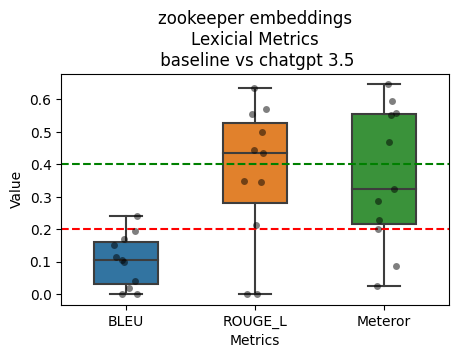

        BLEU   ROUGE_L   Meteror
0   0.014238  0.240000  0.101351
1   0.018442  0.240000  0.233947
2   0.000000  0.320000  0.166667
3   0.018724  0.320000  0.120192
4   0.000000  0.000000  0.000000
5   0.000000  0.000000  0.000000
6   0.018724  0.434783  0.367719
7   0.013609  0.375000  0.371478
8   0.016932  0.322581  0.195652
9   0.017585  0.333333  0.301289
10  0.014238  0.428571  0.271445
mean: [0.01204497 0.27402437 0.19361279]
median: [0.01423835 0.32       0.19565217]
max: [0.01872437 0.43478261 0.37147824]
min: [0. 0. 0.]


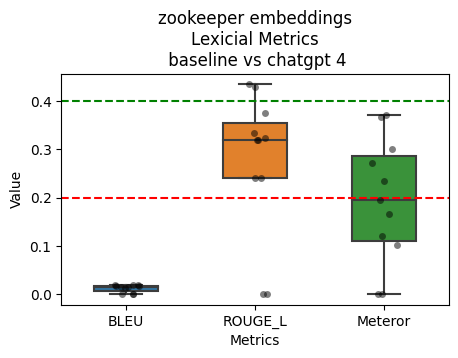

        BLEU   ROUGE_L   Meteror
0   0.014238  0.312500  0.248493
1   0.000000  0.148148  0.051020
2   0.074908  0.424242  0.569967
3   0.000000  0.083333  0.032468
4   0.018724  0.166667  0.202312
5   0.047748  0.695652  0.476190
6   0.018724  0.571429  0.410584
7   0.066015  0.551724  0.616546
8   0.074908  0.352941  0.420755
9   0.020913  0.454545  0.352641
10  0.014238  0.571429  0.407261
mean: [0.03185601 0.3938737  0.34438529]
median: [0.01872437 0.42424242 0.4072613 ]
max: [0.07490792 0.69565217 0.61654604]
min: [0.         0.08333333 0.03246753]


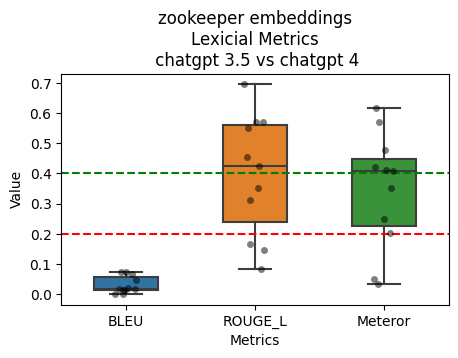

            BLEU   ROUGE_L   Meteror
0   1.567811e-07  0.107843  0.064574
1   4.133925e-07  0.023669  0.006309
2   3.925769e-06  0.160428  0.077913
3   2.768509e-08  0.059172  0.023954
4   1.650993e-12  0.052632  0.023328
5   8.908734e-07  0.151724  0.079965
6   2.126915e-09  0.108108  0.039586
7   7.273130e-08  0.133333  0.069599
8   1.113244e-04  0.205128  0.115223
9   6.905082e-10  0.104575  0.052632
10  7.273130e-08  0.133333  0.069599
mean: [1.06261105e-05 1.12722277e-01 5.66074542e-02]
median: [7.27313020e-08 1.08108108e-01 6.45740530e-02]
max: [1.11324432e-04 2.05128205e-01 1.15222818e-01]
min: [1.65099254e-12 2.36686391e-02 6.30914826e-03]


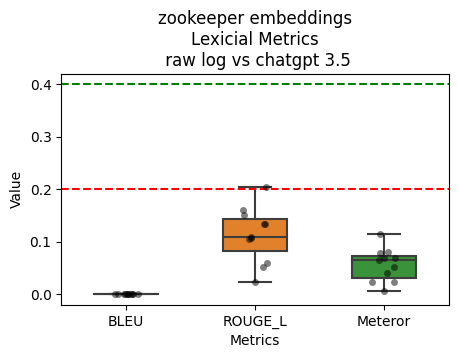

            BLEU   ROUGE_L   Meteror
0   2.849088e-06  0.076923  0.047007
1   0.000000e+00  0.072289  0.028284
2   9.244372e-06  0.126316  0.080622
3   1.173050e-07  0.081871  0.041481
4   3.457495e-11  0.032680  0.028543
5   7.974650e-07  0.123288  0.075956
6   7.615640e-07  0.143791  0.062454
7   5.229547e-05  0.176101  0.100551
8   2.639036e-05  0.126582  0.070321
9   1.798095e-06  0.100629  0.047660
10  1.368260e-05  0.164557  0.101455
mean: [9.81239548e-06 1.11366039e-01 6.22122358e-02]
median: [1.79809511e-06 1.23287671e-01 6.24540779e-02]
max: [5.22954701e-05 1.76100629e-01 1.01454978e-01]
min: [0.         0.03267974 0.0282841 ]


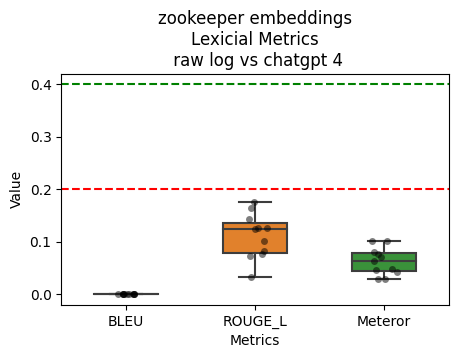

            BLEU   ROUGE_L   Meteror
0   1.966099e-13  0.071066  0.032378
1   2.200886e-07  0.095808  0.025221
2   7.870497e-13  0.078212  0.026111
3   1.056900e-07  0.082353  0.044148
4   0.000000e+00  0.000000  0.003882
5   0.000000e+00  0.000000  0.000000
6   6.878502e-08  0.133333  0.043256
7   2.224352e-06  0.169935  0.075552
8   2.140261e-06  0.169935  0.054494
9   2.796590e-08  0.129032  0.040807
10  6.878502e-08  0.133333  0.050983
mean: [4.41448003e-07 9.66370737e-02 3.60756420e-02]
median: [6.87850186e-08 9.58083832e-02 4.08071710e-02]
max: [2.22435156e-06 1.69934641e-01 7.55522707e-02]
min: [0. 0. 0.]


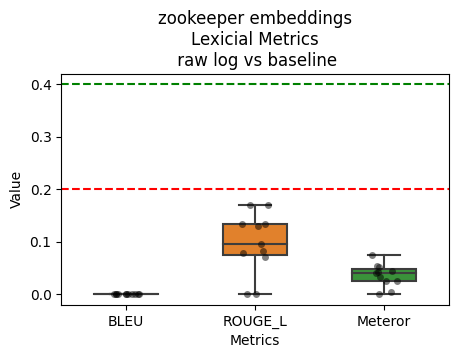

In [ ]:
import pandas as pd
import numpy as np

# files = ['openai_zookeeper.csv','openai_proxifier.csv', 'openai_proxifier.csv']
# labels = ['zookeeper Few-shot','proxifier Zero-shot', 'proxifier Few-shot']
files = ['openai.csv']
labels = ['zookeeper embeddings']
for i, file in enumerate(files):
  df = pd.read_csv(file)
  debug=False

  print(df.shape)
  calc_lexical_metrics(df, labels[i])


## Semantic metrics:
* BERTScore
  * Range from 0 to 1, Higher Is Better
  * 0 indicates no similarity in between
  * 1 indicates that is identical
  * 0.6-0.7 is considered good and indicates that the generated text is similar to the reference in terms of both vocabulary and context.
  * above 0.6 is considered quite good
  
* BLEURT
  * typically range from negative to positive
  * A positive BLEURT score indicates that the generated text is considered better than randomly generated text. The higher the positive score, the better the quality.
  * A negative BLEURT score suggests that the generated text is worse than randomly generated text. The lower the negative score, the worse the quality.
  * A BLEURT score near zero implies that the quality of the generated text is neither better nor worse than randomly generated text.

* NUBIA
  * Range from 0 to 1, Higher Is Better
  * how good of a substitute/replacement the candidate sentence is for the reference sentence.



In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer, score
from nubia_score import Nubia

scorer = BERTScorer(model_type='bert-base-uncased')
nubia = Nubia()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

1042301B [00:00, 12683768.73B/s]
456318B [00:00, 9383835.21B/s]
100%|██████████| 548118077/548118077 [00:14<00:00, 38565165.00B/s]
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.22.2.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
def bert(ref, gen):
  P, R, F1 = scorer.score([gen], [ref])
  if debug:
    print("Precision:", P.item())
    print("Recall:", R.item())
    print("F1 Score:", F1.item())
  return F1.item()

def bleurt(ref, gen):
  cands, refs = [gen], [ref]
  P, R, F1 = score(cands, refs, lang="en", verbose=False)
  if debug:
    print("Precision:", P.item())
    print("Recall:", R.item())
    print("F1 Score:", F1.item())
  return F1.item()

def nubia_s(ref, gen):
  s = nubia.score(ref, gen, verbose=False, get_features=True)
  if debug:
    print(s)
  return s['nubia_score'];

In [ ]:
import pandas as pd
import numpy as np

def calc_semantics_metrics(df, label):
  calc_score_gpt35 = lambda row: pd.Series({
    'BERTScore': bert(row[0], row[1]),
    'BLEURT': bleurt(row[0], row[1]),
    'NUBIA': nubia_s(row[0], row[1]),
  }
  )
  calc_score_gpt4 = lambda row: pd.Series({
    'BERTScore': bert(row[0], row[2]),
    'BLEURT': bleurt(row[0], row[2]),
    'NUBIA': nubia_s(row[0], row[2]),
  }
  )
  calc_score_gpt = lambda row: pd.Series({
    'BERTScore': bert(row[1], row[2]),
    'BLEURT': bleurt(row[1], row[2]),
    'NUBIA': nubia_s(row[1], row[2]),
  }
  )
  calc_score_log_vs_gpt35 = lambda row: pd.Series({
    'BERTScore': bert(row[3], row[1]),
    'BLEURT': bleurt(row[3], row[1]),
    'NUBIA': nubia_s(row[3], row[1]),
  }
  )
  calc_score_log_vs_gpt4 = lambda row: pd.Series({
    'BERTScore': bert(row[3], row[2]),
    'BLEURT': bleurt(row[3], row[2]),
    'NUBIA': nubia_s(row[3], row[2]),
  }
  )

  calc_score_log_vs_ref = lambda row: pd.Series({
    'BERTScore': bert(row[3], row[0]),
    'BLEURT': bleurt(row[3], row[0]),
    'NUBIA': nubia_s(row[3], row[0]),
  }
  )
  process(calc_score_gpt35, label + "\nSemantic Metrics\n baseline vs chatgpt 3.5")
  process(calc_score_gpt4, label + "\nSemantic Metrics\n baseline vs chatgpt 4")
  process(calc_score_gpt, label + "\nSemantic Metrics\n chatgpt 3.5 vs chatgpt 4")
  process(calc_score_log_vs_gpt35, label + "\nSemantic Metrics\n raw log vs chatgpt 3.5")
  process(calc_score_log_vs_gpt4, label + "\nSemantic Metrics\n raw log vs chatgpt 4")
  process(calc_score_log_vs_ref, label + "\nSemantic Metrics\n raw log vs baseline")

(11, 4)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

    BERTScore    BLEURT     NUBIA
0    0.720432  0.883881  0.573207
1    0.664631  0.871123  0.366446
2    0.785106  0.905175  0.489856
3    0.702914  0.881517  0.522345
4    0.494164  0.802274  0.093879
5    0.567415  0.839876  0.140704
6    0.813611  0.921863  0.931829
7    0.841614  0.926533  0.986962
8    0.744555  0.883529  0.602995
9    0.800172  0.922640  0.954612
10   0.844927  0.932466  0.996743
mean: [0.72541288 0.88826159 0.60541618]
median: [0.74455512 0.88388056 0.57320705]
max: [0.84492695 0.93246579 0.99674306]
min: [0.49416369 0.80227435 0.09387881]


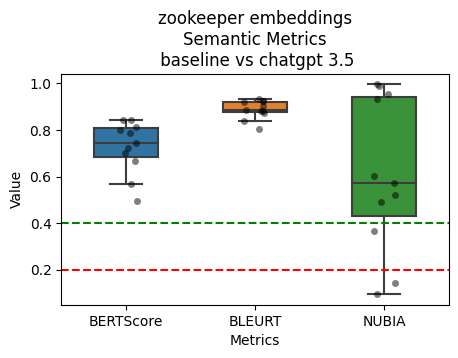

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

    BERTScore    BLEURT     NUBIA
0    0.619411  0.840967  0.188560
1    0.618914  0.847703  0.476910
2    0.653234  0.863982  0.175513
3    0.627092  0.847611  0.435514
4    0.561231  0.831954  0.097581
5    0.538917  0.825393  0.074219
6    0.676916  0.869949  0.691476
7    0.664704  0.873371  0.636483
8    0.636903  0.863839  0.535529
9    0.657617  0.861454  0.497130
10   0.644258  0.870118  0.494081
mean: [0.62719977 0.85421284 0.39118141]
median: [0.63690317 0.86145365 0.47691026]
max: [0.67691559 0.87337101 0.69147644]
min: [0.53891742 0.82539272 0.07421875]


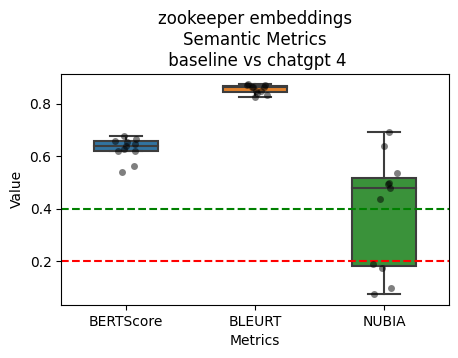

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

    BERTScore    BLEURT     NUBIA
0    0.608489  0.838130  0.403942
1    0.534651  0.828358  0.117330
2    0.681372  0.880887  0.729679
3    0.502127  0.832981  0.300432
4    0.492213  0.810547  0.211876
5    0.621614  0.880658  0.568535
6    0.611552  0.865095  0.674936
7    0.661572  0.872672  0.406852
8    0.612853  0.870237  0.513548
9    0.620508  0.874443  0.461549
10   0.627062  0.865624  0.455221
mean: [0.59763761 0.85633011 0.44035435]
median: [0.61285311 0.86562431 0.45522072]
max: [0.68137223 0.88088697 0.72967913]
min: [0.49221262 0.81054711 0.1173295 ]


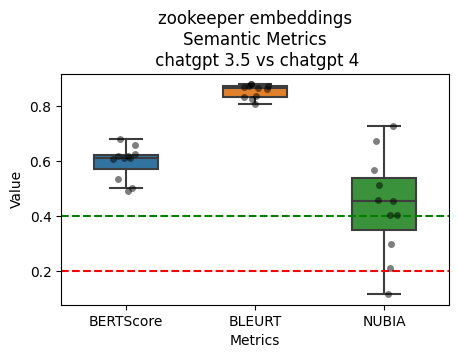

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

    BERTScore    BLEURT     NUBIA
0    0.398803  0.780629  0.907841
1    0.329716  0.739359  0.900552
2    0.424076  0.778074  0.905475
3    0.340198  0.758367  0.907633
4    0.505772  0.778439  0.960410
5    0.508624  0.807040  0.899343
6    0.443084  0.797545  0.899546
7    0.473838  0.796673  0.901858
8    0.503456  0.810467  0.900877
9    0.441593  0.794174  0.900585
10   0.474931  0.797765  0.900101
mean: [0.440372   0.78532108 0.90765661]
median: [0.44308409 0.79417443 0.90087744]
max: [0.5086236  0.8104673  0.96040981]
min: [0.32971573 0.73935878 0.89934347]


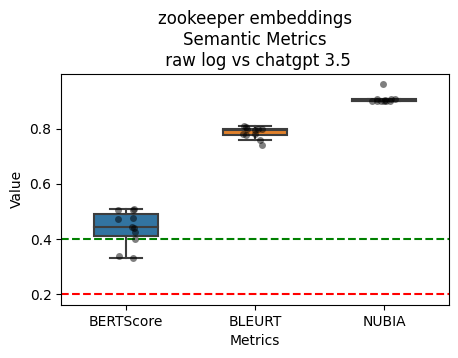

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

    BERTScore    BLEURT     NUBIA
0    0.362723  0.761189  0.907830
1    0.327534  0.742633  0.900726
2    0.369611  0.765244  0.905511
3    0.356191  0.753894  0.907714
4    0.407964  0.750273  0.960406
5    0.407687  0.782495  0.898832
6    0.468704  0.782765  0.901316
7    0.448485  0.779923  0.901039
8    0.409634  0.777895  0.899771
9    0.389284  0.771594  0.900839
10   0.458336  0.779050  0.899568
mean: [0.40055942 0.76790516 0.9075956 ]
median: [0.40768674 0.77159446 0.90103934]
max: [0.46870431 0.78276485 0.96040592]
min: [0.32753405 0.7426331  0.89883151]


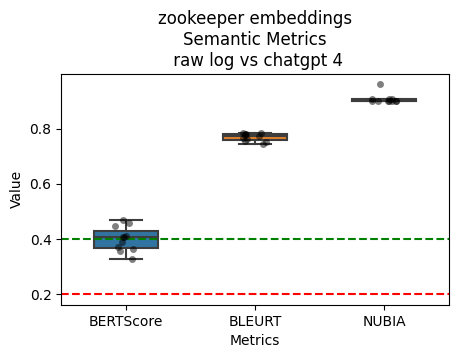

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

    BERTScore    BLEURT     NUBIA
0    0.383194  0.765397  0.907814
1    0.382796  0.752163  0.900441
2    0.368896  0.762664  0.905438
3    0.383851  0.758497  0.907694
4    0.362168  0.736345  0.960402
5    0.321349  0.757353  0.898002
6    0.443874  0.788109  0.899857
7    0.472108  0.788467  0.901291
8    0.457352  0.786790  0.901026
9    0.437621  0.783219  0.901167
10   0.448453  0.784338  0.899414
mean: [0.40560554 0.76939479 0.90750417]
median: [0.38385075 0.76539677 0.90116668]
max: [0.47210768 0.78846747 0.96040169]
min: [0.32134944 0.73634499 0.89800155]


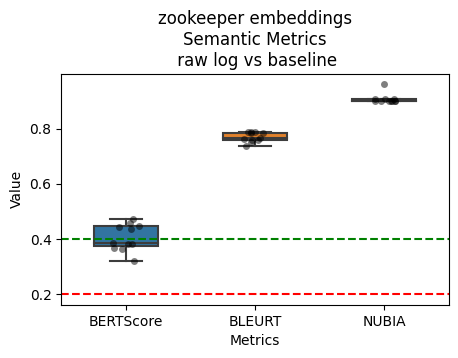

In [ ]:
for i, file in enumerate(files):
  df = pd.read_csv(file)
  debug=False

  print(df.shape)
  calc_semantics_metrics(df, labels[i])